In [1]:
## Montar google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Cargar el archivo desde Google Drive
import pandas as pd

# Especifica la ruta completa del archivo en tu Google Drive
file_path = '/content/drive/MyDrive/MachineLearning/TRAIN/GPT/grouped_trainytrial.xlsx'


# Cargar el archivo Excel en un DataFrame
df = pd.read_excel(file_path)

In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# Codificar la columna 'sentiment' en valores numéricos
label_encoder_sentiment = LabelEncoder()
df['sentiment_numeric'] = label_encoder_sentiment.fit_transform(df['sentiment'])


# Seleccionar características específicas
columnas_seleccionadas = [
    'POS','NEU','NEG',
    'toxicity',
    'tristeza' ,'miedo','enojo','disgusto', 'sorpresa',
    'negaciones',
    'pensamientos suicidas',
    'baja autoestima',
]

# Normalizar solo las columnas numéricas específicas
scaler = MinMaxScaler()
cols_to_normalize = [
    'num_palabras_largas','negaciones','num_palabras_mayusculas',
   'num_palabras_primera_mayuscula', 'num_signos_puntuacion',

]

# Verificar que las columnas a normalizar existan en el DataFrame antes de normalizar
cols_to_normalize = [col for col in cols_to_normalize if col in df.columns]
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

# Seleccionar las características
X = df[columnas_seleccionadas].copy()

# Codificar las etiquetas de la columna 'label'
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])  # 0, 1 y 2 deben estar en esta columna

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)




Nuevo


In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Crear y entrenar el modelo SVM con escalado y balanceo interno
svm_model = make_pipeline(
    StandardScaler(),
    SVC(kernel='linear', class_weight='balanced', random_state=42)
)



svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

# Evaluación
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Reporte por clase
print("\nReporte por clase:")
print(classification_report(y_test, y_pred, target_names=[str(cls) for cls in label_encoder.classes_]))


Accuracy: 0.7877
Precision: 0.7945
Recall: 0.7877
F1 Score: 0.7880

Reporte por clase:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85        76
           1       0.74      0.69      0.71        51
           2       0.65      0.89      0.76        19

    accuracy                           0.79       146
   macro avg       0.75      0.80      0.77       146
weighted avg       0.79      0.79      0.79       146



**Mejores hiperparametros**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Pipeline: escalado + SVM
pipeline = make_pipeline(
    StandardScaler(),
    SVC(class_weight='balanced', random_state=42)
)

# Grid de hiperparámetros
param_grid = {
    'svc__C': [1, 10],
    'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svc__gamma': ['scale', 'auto']
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    verbose=1,
    n_jobs=-1
)

# Entrenar el modelo
grid_search.fit(X_train, y_train)

# Mejor estimador
best_model = grid_search.best_estimator_

# Predicciones
y_pred = best_model.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Resultados
print("✅ Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("🔍 Métricas en el conjunto de prueba:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
✅ Mejores hiperparámetros encontrados: {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
🔍 Métricas en el conjunto de prueba:
Accuracy: 0.7534
Precision: 0.7782
Recall: 0.7534
F1 Score: 0.7587


**Validacion cruzada**

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC

# Inicializar el modelo SVM con los mejores parámetros
svm_best = SVC(C=100, kernel='linear', gamma='scale')

# Configurar métricas para la validación cruzada
scoring_metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

# Realizar validación cruzada con múltiples métricas
cv_results = cross_validate(svm_best, X_train, y_train, cv=5, scoring=scoring_metrics, return_train_score=False, n_jobs=-1)

# Calcular promedios y desviaciones estándar
mean_accuracy = cv_results['test_accuracy'].mean()
std_accuracy = cv_results['test_accuracy'].std()
mean_precision = cv_results['test_precision_weighted'].mean()
std_precision = cv_results['test_precision_weighted'].std()
mean_recall = cv_results['test_recall_weighted'].mean()
std_recall = cv_results['test_recall_weighted'].std()
mean_f1 = cv_results['test_f1_weighted'].mean()
std_f1 = cv_results['test_f1_weighted'].std()

# Mostrar resultados
print("Resultados de Validación Cruzada con los Mejores Hiperparámetros:")
print(f"Accuracy Promedio: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Precision Promedio: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Recall Promedio: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"F1 Score Promedio: {mean_f1:.4f} ± {std_f1:.4f}")


Resultados de Validación Cruzada con los Mejores Hiperparámetros:
Accuracy Promedio: 0.7111 ± 0.0507
Precision Promedio: 0.7150 ± 0.0602
Recall Promedio: 0.7111 ± 0.0507
F1 Score Promedio: 0.7030 ± 0.0534


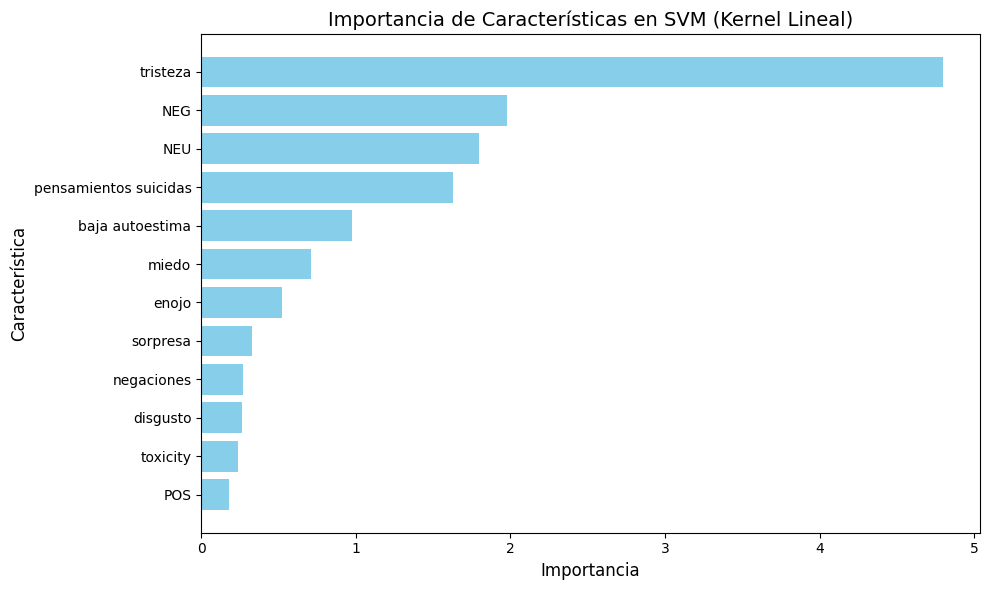

In [ ]:
#importancia de caracteristicas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC

# Supongamos que ya tienes X_train y y_train
# Asegúrate de usar un kernel lineal
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Extraer los coeficientes del modelo SVM lineal
# (Solo funciona si usas kernel='linear')
importancia = np.abs(svm_model.coef_[0])  # Tomamos el valor absoluto de los coeficientes

# Crear un DataFrame para las características y sus importancias
df_importancia = pd.DataFrame({
    'Característica': X_train.columns,
    'Importancia': importancia
})

# Ordenar las características por importancia
df_importancia = df_importancia.sort_values(by='Importancia', ascending=False)

# Graficar las importancias
plt.figure(figsize=(10, 6))
plt.barh(df_importancia['Característica'], df_importancia['Importancia'], color='skyblue')
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.title('Importancia de Características en SVM (Kernel Lineal)', fontsize=14)
plt.gca().invert_yaxis()  # Para mostrar las más importantes arriba
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Combinaciones manuales a probar
combinaciones_svm = [
    {'kernel': 'rbf', 'C': 1, 'gamma': 'scale'},
    {'kernel': 'rbf', 'C': 10, 'gamma': 'scale'},
    {'kernel': 'linear', 'C': 1, 'gamma': 'scale'},
    {'kernel': 'poly', 'C': 1, 'gamma': 'scale'},
    {'kernel': 'sigmoid', 'C': 1, 'gamma': 'auto'},
    {'kernel': 'rbf', 'C': 0.1, 'gamma': 'scale'},
    {'kernel': 'linear', 'C': 10, 'gamma': 'scale'}
]

# Almacenar resultados
resultados = []

# Ejecutar pruebas para cada configuración
for i, config in enumerate(combinaciones_svm, start=1):
    print(f"\n🔍 Evaluando combinación #{i}: {config}")

    pipeline = make_pipeline(
        StandardScaler(),
        SVC(kernel=config['kernel'],
            C=config['C'],
            gamma=config['gamma'],
            class_weight='balanced',
            random_state=42)
    )

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"📊 Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

    resultados.append({
        'Combinación': i,
        'Kernel': config['kernel'],
        'C': config['C'],
        'Gamma': config['gamma'],
        'Accuracy': round(acc, 4),
        'Precision': round(prec, 4),
        'Recall': round(rec, 4),
        'F1 Score': round(f1, 4)
    })

# Mostrar como tabla
df_resultados_svm = pd.DataFrame(resultados)
print("\n📋 Resultados generales:")
print(df_resultados_svm)



🔍 Evaluando combinación #1: {'kernel': 'rbf', 'C': 1, 'gamma': 'scale'}
📊 Accuracy: 0.7671 | Precision: 0.7755 | Recall: 0.7671 | F1: 0.7688

🔍 Evaluando combinación #2: {'kernel': 'rbf', 'C': 10, 'gamma': 'scale'}
📊 Accuracy: 0.7397 | Precision: 0.7653 | Recall: 0.7397 | F1: 0.7461

🔍 Evaluando combinación #3: {'kernel': 'linear', 'C': 1, 'gamma': 'scale'}
📊 Accuracy: 0.7877 | Precision: 0.7945 | Recall: 0.7877 | F1: 0.7880

🔍 Evaluando combinación #4: {'kernel': 'poly', 'C': 1, 'gamma': 'scale'}
📊 Accuracy: 0.7260 | Precision: 0.7655 | Recall: 0.7260 | F1: 0.7245

🔍 Evaluando combinación #5: {'kernel': 'sigmoid', 'C': 1, 'gamma': 'auto'}
📊 Accuracy: 0.7260 | Precision: 0.7343 | Recall: 0.7260 | F1: 0.7267

🔍 Evaluando combinación #6: {'kernel': 'rbf', 'C': 0.1, 'gamma': 'scale'}
📊 Accuracy: 0.7397 | Precision: 0.7427 | Recall: 0.7397 | F1: 0.7408

🔍 Evaluando combinación #7: {'kernel': 'linear', 'C': 10, 'gamma': 'scale'}
📊 Accuracy: 0.7808 | Precision: 0.7930 | Recall: 0.7808 | F1: